#   <b>Proyección de precios de la distribuidora</b>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import plotly.express as px
import plotly.graph_objects as go
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import acf
import pmdarima as pm
import plotly.io as pio
#Train data
from sklearn.model_selection import train_test_split
#FAMD
from prince import FAMD
#Normalization
from sklearn.preprocessing import StandardScaler
#Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

#Evaluation
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import pandas_profiling as pp
from sklearn.model_selection import GridSearchCV








C:\Users\Vskah\AppData\Local\Temp\ipykernel_10892\523957112.py:22: DeprecationWarning: `import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profiling` instead.
  import pandas_profiling as pp


#  Carga y limpieza de datos

En primer lugar se carga el dataset que contiene las fechas de vigencias de las licitaciones, para obtener las licitaciones que ya expiraron o expirarán este año, con el fin de no proyectar precios vencidos.

In [ ]:
ruta_py=os.path.dirname(os.path.abspath("__file__"))

In [ ]:

nombre_vigencia='precios_com_reg_licitaciongx.csv'
nombre_data= 'precios_com_reg_indexacioncontratodetalle_202304052006.csv'

ruta_completa_vig=ruta_py+'//'+nombre_vigencia
ruta_completa_data= ruta_py+'//'+nombre_data


In [ ]:
#Se carga archivo que contiene las vigencias
precios_com_reg_licitaciongx=pd.read_csv(ruta_completa_vig,sep=';')
precios_com_reg_licitaciongx.head()

,Unnamed: 0,idlicitaciongx,idlicitacion,licitacion,rexbases,iddecrpnudo,decpnudo,tipodecreto,modalidad,mesreferencia,...,idptooferta,ptooferta,tipobloque,bloque,precioenergia,vigenciainicio,vigenciafin,observacion,created_at,update_at
0,0,10,29,SIC 2013/03_2,533/2014,8,4T/2013,Decreto PN,DS 4,2014-12-01,...,28,POLPAICO 220,BB,BS1B,88.998,2016-01-01,2030-12-31,NaN,2022-02-02 00:19:57.115012,2022-02-02 00:23:27
1,1,8,29,SIC 2013/03_2,533/2014,8,4T/2013,Decreto PN,DS 4,2014-12-01,...,28,POLPAICO 220,BB,BS1A,111.133,2016-01-01,2030-12-31,NaN,2022-02-02 00:19:57.115012,2022-02-02 00:23:27
2,2,11,29,SIC 2013/03_2,533/2014,8,4T/2013,Decreto PN,DS 4,2014-12-01,...,28,POLPAICO 220,BB,BS1B,111.133,2016-01-01,2030-12-31,NaN,2022-02-02 00:19:57.115012,2022-02-02 00:23:27
3,3,15,29,SIC 2013/03_2,533/2014,8,4T/2013,Decreto PN,DS 4,2014-12-01,...,28,POLPAICO 220,BB,BS1C,111.133,2016-01-01,2030-12-31,NaN,2022-02-02 00:19:57.115012,2022-02-02 00:23:27
4,4,41,30,SIC 2013/03_2 (EMELECTRIC),533/2014,8,4T/2013,Decreto PN,DS 4,2014-12-01,...,28,POLPAICO 220,BB,BS1A,111.133,2016-01-01,2030-12-31,Agregado por Tarificación,2022-02-02 00:19:57.115012,2022-02-02 00:23:27


Se genera un nuevo dataset con los valores de las licitaciones, su fecha de inicio y de expiración.

In [ ]:
#se genera un nuevo dataset solo con las fechas de vigencias y las licitaciones
vigencias= precios_com_reg_licitaciongx[['licitacion', 'vigenciainicio','vigenciafin']]
vigencias.head()

,licitacion,vigenciainicio,vigenciafin
0,SIC 2013/03_2,2016-01-01,2030-12-31
1,SIC 2013/03_2,2016-01-01,2030-12-31
2,SIC 2013/03_2,2016-01-01,2030-12-31
3,SIC 2013/03_2,2016-01-01,2030-12-31
4,SIC 2013/03_2 (EMELECTRIC),2016-01-01,2030-12-31


Se puede observar que las fechas no se encuentran en formato datatime de manera que requieren ser modififcadas.

In [ ]:
vigencias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 236 entries, 0 to 235
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   licitacion      236 non-null    object
 1   vigenciainicio  236 non-null    object
 2   vigenciafin     236 non-null    object
dtypes: object(3)
memory usage: 5.7+ KB


Se transforman las fechas de inicio y fin de las vigencias a formato datatime para poder trabajarlas de mejor manera.

In [ ]:
#se pasa a datatime las fechas de las vigencias
vigencias['vigenciainicio'] = pd.to_datetime(vigencias['vigenciainicio'])
vigencias['vigenciafin'] = pd.to_datetime(vigencias['vigenciafin'])

C:\Users\Vskah\AppData\Local\Temp\ipykernel_10892\3530378407.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vigencias['vigenciainicio'] = pd.to_datetime(vigencias['vigenciainicio'])
C:\Users\Vskah\AppData\Local\Temp\ipykernel_10892\3530378407.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vigencias['vigenciafin'] = pd.to_datetime(vigencias['vigenciafin'])


Se calcula el tiempo de las vigencias de los contratos.

In [ ]:
vigencias['tiempovigencia'] = (vigencias['vigenciafin']-vigencias['vigenciainicio']).astype('<m8[Y]')


C:\Users\Vskah\AppData\Local\Temp\ipykernel_10892\1191411901.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vigencias['tiempovigencia'] = (vigencias['vigenciafin']-vigencias['vigenciainicio']).astype('<m8[Y]')


In [ ]:
vigencias.head()

,licitacion,vigenciainicio,vigenciafin,tiempovigencia
0,SIC 2013/03_2,2016-01-01,2030-12-31,14.0
1,SIC 2013/03_2,2016-01-01,2030-12-31,14.0
2,SIC 2013/03_2,2016-01-01,2030-12-31,14.0
3,SIC 2013/03_2,2016-01-01,2030-12-31,14.0
4,SIC 2013/03_2 (EMELECTRIC),2016-01-01,2030-12-31,14.0


Se chequea si hay elementos duplicados en la base de datos.

In [ ]:
duplicate_rows = vigencias[vigencias.duplicated()]
print("number of duplicate rows: ", duplicate_rows.shape)

number of duplicate rows:  (180, 4)


Se eliminan los duplicados.

In [ ]:
vigencias=vigencias.drop_duplicates()
vigencias.head()

,licitacion,vigenciainicio,vigenciafin,tiempovigencia
0,SIC 2013/03_2,2016-01-01,2030-12-31,14.0
4,SIC 2013/03_2 (EMELECTRIC),2016-01-01,2030-12-31,14.0
9,SIC 2013/03,2014-01-01,2025-12-31,11.0
11,SIC 2013/03 (EMELECTRIC),2014-01-01,2025-12-31,11.0
15,EMEL-SIC 2006/01-2 (EMELECTRIC),2010-01-01,2024-12-31,14.0


In [ ]:
vigencias['vigenciafin'].max()

Timestamp('2041-12-31 00:00:00')

Por otro lado se genera un nuevo dataframe donde se eliminan los duplicados dejando solo las licitaciones en valores únicos, esto con el fin de graficarlas posteriormente.

Se eliminan los duplicados y se vuelve a comprobar su existencia.

In [ ]:
vigencias_unicas=vigencias.drop_duplicates(subset='licitacion')
vigencias_unicas.head()

,licitacion,vigenciainicio,vigenciafin,tiempovigencia
0,SIC 2013/03_2,2016-01-01,2030-12-31,14.0
4,SIC 2013/03_2 (EMELECTRIC),2016-01-01,2030-12-31,14.0
9,SIC 2013/03,2014-01-01,2025-12-31,11.0
11,SIC 2013/03 (EMELECTRIC),2014-01-01,2025-12-31,11.0
15,EMEL-SIC 2006/01-2 (EMELECTRIC),2010-01-01,2024-12-31,14.0


In [ ]:
duplicate_rows = vigencias_unicas[vigencias_unicas.duplicated()]
print("number of duplicate rows: ", duplicate_rows.shape)

number of duplicate rows:  (0, 4)


Se filtran todas aquellas fechas cuyo vencimiento límite sea hasta final del año 2022, pues esos datos no requieren ser proyectados a futuro.

In [ ]:
#Se filtran las vigencias vencidas
var=vigencias['vigenciafin'] <= '31-12-2022'
vigencias = vigencias[var]
vigencias.head()

C:\Users\Vskah\AppData\Local\Temp\ipykernel_10892\3391736610.py:2: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  var=vigencias['vigenciafin'] <= '31-12-2022'


,licitacion,vigenciainicio,vigenciafin,tiempovigencia
16,EMEL-SIC 2006/01 (EMELECTRIC),2010-01-01,2019-12-31,9.0
17,CHL 2006/02,2011-01-01,2021-12-31,10.0
20,CHL 2006/01,2010-01-01,2020-12-31,10.0
22,CHL 2006/01,2010-01-01,2022-12-31,12.0
26,EMEL-SIC 2006/01 (EMETAL),2010-01-01,2019-12-31,9.0


In [ ]:
vigencias.shape

(10, 4)

Se genera una lista con todas las licitaciones expiradas.

In [ ]:
#se genera una lista con las licitaciones expiradas
licitacion_expirada= list(vigencias['licitacion'])

Se carga la base de datos a utilizar en el resto del trabajo.

In [ ]:
indexacion_contratos=pd.read_csv(ruta_completa_data)
indexacion_contratos.head()

,versionindex,mesindexacion,version,idlicitaciongx,licitacion,generadora,tipobloque,bloque,ptooferta,precioenergiabase,...,fechaactual,valoractual,factorindexacion,precioindexadoponderado,flagind,observacion,created_at,id,tipoindexacion,preciopotenciabase
0,240,2012-12-01,V1,76,CHL 2006/02,ENDESA,BV,BB1,POLPAICO 220,61.00,...,2012-09-01 00:00:00.000,2.58,0.352941,6.458824,0,NaN,2022-02-11 16:10:37.644,1002867,Mes,7.2492
1,240,2012-12-01,V1,81,CHL 2006/02,ENDESA,BB,BB3,POLPAICO 220,61.00,...,2012-09-01 00:00:00.000,2.58,0.352941,6.458824,0,NaN,2022-02-11 16:10:37.644,1002868,Mes,7.2492
2,240,2012-12-01,V1,82,CHL 2006/02,ENDESA,BV,BB3,POLPAICO 220,61.00,...,2012-09-01 00:00:00.000,2.58,0.352941,6.458824,0,NaN,2022-02-11 16:10:37.644,1002869,Mes,7.2492
3,240,2012-12-01,V1,75,CHL 2006/02,ENDESA,BB,BB1,POLPAICO 220,61.00,...,2012-09-01 00:00:00.000,2.58,0.352941,6.458824,0,NaN,2022-02-11 16:10:37.644,1002870,Mes,7.2492
4,240,2012-12-01,V1,123,EMEL-SING 2008/01,E-CL,BB,BS1,CRUCERO 220,89.99,...,2012-09-01 00:00:00.000,2.77,0.734748,39.275264,0,Agregado por Tarificación,2022-02-11 16:10:37.644,1002871,Mes,8.5659


Se da inicio con un dataset que contiene 109.974 filas y 30 columnas.

In [ ]:
indexacion_contratos.shape

(109974, 30)

In [ ]:
indexacion_contratos['mesindexacion'].max()

'2022-12-01'

Se observa que todos los datos con enteros u object, las fechas no estan en formato datatime.

In [ ]:
indexacion_contratos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109974 entries, 0 to 109973
Data columns (total 30 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   versionindex             109974 non-null  int64  
 1   mesindexacion            109974 non-null  object 
 2   version                  109974 non-null  object 
 3   idlicitaciongx           109974 non-null  int64  
 4   licitacion               109974 non-null  object 
 5   generadora               109974 non-null  object 
 6   tipobloque               109974 non-null  object 
 7   bloque                   109974 non-null  object 
 8   ptooferta                109974 non-null  object 
 9   precioenergiabase        109974 non-null  float64
 10  iddecrpnudo              109974 non-null  int64  
 11  decpnudo                 109974 non-null  object 
 12  tipodecreto              109974 non-null  object 
 13  tipoindex                109974 non-null  object 
 14  inde

Se revisa si hay datos duplicados en la base de datos, no encontrando datos duplicados.

In [ ]:
duplicate_rows = indexacion_contratos[indexacion_contratos.duplicated()]
print("number of duplicate rows: ", duplicate_rows.shape)

number of duplicate rows:  (0, 30)


Se eliminan las licitaciones vencidas, quedando con un total de filas de 77.562, y 30 columnas.

In [ ]:
for i in licitacion_expirada:
    indexacion_contratos.drop(indexacion_contratos[(indexacion_contratos['licitacion'] == i)].index, inplace=True)


indexacion_contratos.shape

(77562, 30)

In [ ]:
porcentaje=(77562/109974)*100
print(f'El porcentaje de datos que se mantienen en la base es de {round(porcentaje,2)}%')

El porcentaje de datos que se mantienen en la base es de 70.53%


Se cuentan los valores nulos, en donde solo la variable observaciones tiene valores de este tipo, los cuales ascienden a 33.816.

In [ ]:
# Let's count number of null entries per feature
missing_values = list(indexacion_contratos.isna().sum())
# missing values is a list of the number of missing values in each column

cols = list(indexacion_contratos.columns)
col_final = []
for i in range(len(cols)):
    if (missing_values[i] == 0):
        cols[i]="Others"
d = dict(zip(cols, missing_values)) # making a dicionary for the missing values

print("Number of Missing Values per feature >>")
missing_vals = pd.DataFrame(d, index=["Missing Values"]) # Making a custom dataframe from dict d
missing_vals.head()

Number of Missing Values per feature >>


,Others,observacion
Missing Values,0,33816


Se revisan los valores únicos para cada variable, con el fin de revisar si existen variables que solo tomen un valor. Se encuentra que las variables Flagind y Version tienen un solo valor que se repite para cada elemento de la tabla.

In [ ]:
for i in indexacion_contratos.columns:
    u=indexacion_contratos[i].unique()
    print('--------------------------')
    print(i,':')
    print(u)

--------------------------
versionindex :
[240 292 262 241  25  23 242 323 322 243 244 245 263 246 247 248 249 250
 293 251 252  31 253 254 255 256 257 258 294 295 296 297 298 299 300 301
 302 303 304 305 306 307 308 309 310 311 312 144 313 314 315 316 317 318
 319 320 321  32  70  33 326 328 383 332 335 337 388 264 339 353 362 259
 364 205 206 207 208 209 210 211 212 260 213 214 215 216 217 218 219 220
 221 222 223 224 261 225 226 227 228 229 230 231 232 233 234 235 236 237
 238 239 265 266 267 268 269 270 271 272 273 274 275 276 277 278 279 280
 281 282 283 284 285 286 287 288 289 290 291 377 368  34 379 373 375  30
  18  19  20  21 370  22  35  60  61  17  63  67]
--------------------------
mesindexacion :
['2012-12-01' '2017-04-01' '2014-10-01' '2013-01-01' '2021-06-01'
 '2020-07-01' '2013-02-01' '2019-12-01' '2019-11-01' '2013-03-01'
 '2013-04-01' '2013-05-01' '2014-11-01' '2013-06-01' '2013-07-01'
 '2013-08-01' '2013-09-01' '2013-10-01' '2017-05-01' '2013-11-01'
 '2013-12-01' '20

Se eliminan las columnas flagind y version debido a que es el mismo dato para cada fila del dataframe, el valor observacion y los id contenidos en la base, los cuales corresponden a id, idlicitaciongx, ididdecrpnudo  pues no son relevantes para el trabajo.

In [ ]:
indexacion_contratos_2=indexacion_contratos.drop(['flagind'],axis=1)
indexacion_contratos_2=indexacion_contratos_2.drop(['version'],axis=1)
indexacion_contratos_2=indexacion_contratos_2.drop(['observacion'],axis=1)
indexacion_contratos_2=indexacion_contratos_2.drop(['id'],axis=1)
indexacion_contratos_2=indexacion_contratos_2.drop(['idlicitaciongx'],axis=1)
indexacion_contratos_2=indexacion_contratos_2.drop(['iddecrpnudo'],axis=1)


Al analizar la definición de las variables se hace evidente la necesidad de eliminar las columnas created_at, que representa la fecha de creacion del archivo, y la columna version index, que es la versión del cálculo del índice, y no influyen en el cálculo del precio.

In [ ]:
indexacion_contratos_2=indexacion_contratos_2.drop(['created_at'],axis=1)
indexacion_contratos_2=indexacion_contratos_2.drop(['versionindex'],axis=1)

Se transforman las fechas a formato datatime.

In [ ]:
indexacion_contratos_2[['mesindexacion', 'mesreferencia','fechaactual','fechabase']] = indexacion_contratos_2[['mesindexacion', 'mesreferencia','fechaactual','fechabase']].apply(pd.to_datetime, format='%Y-%m-%d')

In [ ]:
indexacion_contratos_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 77562 entries, 4 to 109973
Data columns (total 22 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   mesindexacion            77562 non-null  datetime64[ns]
 1   licitacion               77562 non-null  object        
 2   generadora               77562 non-null  object        
 3   tipobloque               77562 non-null  object        
 4   bloque                   77562 non-null  object        
 5   ptooferta                77562 non-null  object        
 6   precioenergiabase        77562 non-null  float64       
 7   decpnudo                 77562 non-null  object        
 8   tipodecreto              77562 non-null  object        
 9   tipoindex                77562 non-null  object        
 10  index                    77562 non-null  object        
 11  mesreferencia            77562 non-null  datetime64[ns]
 12  rezago                   77562 

Al mesidexacion se le divide en año día y mes, y se elimina la variable mesindexacion, se repite el procedimiento para las otras fechas del dataframe.

In [ ]:
indexacion_contratos_2['diaindexacion'] =indexacion_contratos_2['mesindexacion'].apply(lambda x:x.strftime('%d'))
indexacion_contratos_2['añoindexacion'] = indexacion_contratos_2['mesindexacion'].apply(lambda x:x.strftime('%Y'))
indexacion_contratos_2['mesindexacion2'] =indexacion_contratos_2['mesindexacion'].apply(lambda x:x.strftime('%m'))


In [ ]:
indexacion_contratos_2['diaactual'] =indexacion_contratos_2['fechaactual'].apply(lambda x:x.strftime('%d'))
indexacion_contratos_2['añoactual'] = indexacion_contratos_2['fechaactual'].apply(lambda x:x.strftime('%Y'))
indexacion_contratos_2['mesactual'] =indexacion_contratos_2['fechaactual'].apply(lambda x:x.strftime('%m'))


In [ ]:
indexacion_contratos_2['diareferencia'] =indexacion_contratos_2['mesreferencia'].apply(lambda x:x.strftime('%d'))
indexacion_contratos_2['añoreferencia'] = indexacion_contratos_2['mesreferencia'].apply(lambda x:x.strftime('%Y'))
indexacion_contratos_2['mesreferencia'] =indexacion_contratos_2['mesreferencia'].apply(lambda x:x.strftime('%m'))


In [ ]:
indexacion_contratos_2['diabase'] =indexacion_contratos_2['fechabase'].apply(lambda x:x.strftime('%d'))
indexacion_contratos_2['añobase'] = indexacion_contratos_2['fechabase'].apply(lambda x:x.strftime('%Y'))
indexacion_contratos_2['mesbase'] =indexacion_contratos_2['fechabase'].apply(lambda x:x.strftime('%m'))


In [ ]:
indexacion_contratos_2=indexacion_contratos_2.drop(['fechaactual'],axis=1)
indexacion_contratos_2=indexacion_contratos_2.drop(['fechabase'],axis=1)

Se visualizan aquellos datos que son únicos para conocer si varía cada variable.

In [ ]:
for i in indexacion_contratos_2.columns:
    u=indexacion_contratos_2[i].unique()
    print('--------------------------')
    print(i,':')
    print(u)

--------------------------
mesindexacion :
['2012-12-01T00:00:00.000000000' '2017-04-01T00:00:00.000000000'
 '2014-10-01T00:00:00.000000000' '2013-01-01T00:00:00.000000000'
 '2021-06-01T00:00:00.000000000' '2020-07-01T00:00:00.000000000'
 '2013-02-01T00:00:00.000000000' '2019-12-01T00:00:00.000000000'
 '2019-11-01T00:00:00.000000000' '2013-03-01T00:00:00.000000000'
 '2013-04-01T00:00:00.000000000' '2013-05-01T00:00:00.000000000'
 '2014-11-01T00:00:00.000000000' '2013-06-01T00:00:00.000000000'
 '2013-07-01T00:00:00.000000000' '2013-08-01T00:00:00.000000000'
 '2013-09-01T00:00:00.000000000' '2013-10-01T00:00:00.000000000'
 '2017-05-01T00:00:00.000000000' '2013-11-01T00:00:00.000000000'
 '2013-12-01T00:00:00.000000000' '2020-08-01T00:00:00.000000000'
 '2014-01-01T00:00:00.000000000' '2014-02-01T00:00:00.000000000'
 '2014-03-01T00:00:00.000000000' '2014-04-01T00:00:00.000000000'
 '2014-05-01T00:00:00.000000000' '2014-06-01T00:00:00.000000000'
 '2017-06-01T00:00:00.000000000' '2017-07-01T00

Se debe eliminar dia diaindexacion, diaactual y diareferencia pues tienen un único valor para cada fila del dataframe.

In [ ]:
indexacion_contratos_2=indexacion_contratos_2.drop(['diaactual'],axis=1)
indexacion_contratos_2=indexacion_contratos_2.drop(['diareferencia'],axis=1)
indexacion_contratos_2=indexacion_contratos_2.drop(['diaindexacion'],axis=1)
indexacion_contratos_2=indexacion_contratos_2.drop(['diabase'],axis=1)

In [ ]:
indexacion_contratos_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 77562 entries, 4 to 109973
Data columns (total 27 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   mesindexacion            77562 non-null  datetime64[ns]
 1   licitacion               77562 non-null  object        
 2   generadora               77562 non-null  object        
 3   tipobloque               77562 non-null  object        
 4   bloque                   77562 non-null  object        
 5   ptooferta                77562 non-null  object        
 6   precioenergiabase        77562 non-null  float64       
 7   decpnudo                 77562 non-null  object        
 8   tipodecreto              77562 non-null  object        
 9   tipoindex                77562 non-null  object        
 10  index                    77562 non-null  object        
 11  mesreferencia            77562 non-null  object        
 12  rezago                   77562 

En conversación con el negocio, se explicó que los valores correspondientes a ITD no sirven para el cálculo, pues ellos solo necesitan la predicción para los meses, de manera que se filtra el mes.

In [ ]:
var=indexacion_contratos_2['tipoindexacion'] == 'Mes'
indexacion_contratos_2 = indexacion_contratos_2[var]
indexacion_contratos_2.head()

,mesindexacion,licitacion,generadora,tipobloque,bloque,ptooferta,precioenergiabase,decpnudo,tipodecreto,tipoindex,...,precioindexadoponderado,tipoindexacion,preciopotenciabase,añoindexacion,mesindexacion2,añoactual,mesactual,añoreferencia,añobase,mesbase
4,2012-12-01,EMEL-SING 2008/01,E-CL,BB,BS1,CRUCERO 220,89.990,130/2008,Decreto PN SING,E1,...,39.275264,Mes,8.5659,2012,12,2012,09,2009,2009,06
5,2012-12-01,EMEL-SING 2008/01,E-CL,BV,BS1,CRUCERO 220,89.990,130/2008,Decreto PN SING,E1,...,39.275264,Mes,8.5659,2012,12,2012,09,2009,2009,06
6,2012-12-01,EMEL-SING 2008/01 (ELECDA),E-CL,BV,BS1,CRUCERO 220,89.990,130/2008,Decreto PN SING,E1,...,39.275264,Mes,8.5659,2012,12,2012,09,2009,2009,06
7,2012-12-01,EMEL-SING 2008/01 (ELECDA),E-CL,BB,BS1,CRUCERO 220,89.990,130/2008,Decreto PN SING,E1,...,39.275264,Mes,8.5659,2012,12,2012,09,2009,2009,06
16,2012-12-01,CHQ 2006/01,ENDESA,BB,BB1,QUILLOTA 220,51.037,283/2005,Decreto PN,E3,...,42.008249,Mes,6.9704,2012,12,2012,09,2006,2005,12


Además se menciona que aquellos tipoindex con valor P tampoco sirven para el cálculo de manera que también se filtran.

In [ ]:
var2=indexacion_contratos_2['tipoindex'] != 'P'
indexacion_contratos_2 = indexacion_contratos_2[var2]
indexacion_contratos_2.head()

,mesindexacion,licitacion,generadora,tipobloque,bloque,ptooferta,precioenergiabase,decpnudo,tipodecreto,tipoindex,...,precioindexadoponderado,tipoindexacion,preciopotenciabase,añoindexacion,mesindexacion2,añoactual,mesactual,añoreferencia,añobase,mesbase
4,2012-12-01,EMEL-SING 2008/01,E-CL,BB,BS1,CRUCERO 220,89.990,130/2008,Decreto PN SING,E1,...,39.275264,Mes,8.5659,2012,12,2012,09,2009,2009,06
5,2012-12-01,EMEL-SING 2008/01,E-CL,BV,BS1,CRUCERO 220,89.990,130/2008,Decreto PN SING,E1,...,39.275264,Mes,8.5659,2012,12,2012,09,2009,2009,06
6,2012-12-01,EMEL-SING 2008/01 (ELECDA),E-CL,BV,BS1,CRUCERO 220,89.990,130/2008,Decreto PN SING,E1,...,39.275264,Mes,8.5659,2012,12,2012,09,2009,2009,06
7,2012-12-01,EMEL-SING 2008/01 (ELECDA),E-CL,BB,BS1,CRUCERO 220,89.990,130/2008,Decreto PN SING,E1,...,39.275264,Mes,8.5659,2012,12,2012,09,2009,2009,06
16,2012-12-01,CHQ 2006/01,ENDESA,BB,BB1,QUILLOTA 220,51.037,283/2005,Decreto PN,E3,...,42.008249,Mes,6.9704,2012,12,2012,09,2006,2005,12


Se queda con un total de 22.683 filas.

In [ ]:
indexacion_contratos_2.shape

(22683, 27)

In [ ]:
porcentaje=(22683/109974)*100
print(f'El porcentaje de datos que se mantienen en la base es de {round(porcentaje,2)}%')

El porcentaje de datos que se mantienen en la base es de 20.63%


Se revisa que se hayan eliminado los valores ITD y P del dataset.

In [ ]:
print(indexacion_contratos_2['tipoindexacion'].unique())
print(indexacion_contratos_2['tipoindex'].unique())


['Mes']
['E1' 'E3' 'E2' 'E4']


Se elimina el tipo index pues cada índice tiene un significado diferente dependiendo de la fórmula en la que se utiliza, no siempre hay relación entre el índice de una columna y el de otra.

In [ ]:
indexacion_contratos_2=indexacion_contratos_2.drop(['tipoindex'],axis=1)

Se elimina la columna tipoindexacion pues solo está compuesta por el valor mes.

In [ ]:
indexacion_contratos_2=indexacion_contratos_2.drop(['tipoindexacion'],axis=1)

Se restablecen los índices a predeterminados.

In [ ]:
indexacion_contratos_2.reset_index(drop=True)

,mesindexacion,licitacion,generadora,tipobloque,bloque,ptooferta,precioenergiabase,decpnudo,tipodecreto,index,...,factorindexacion,precioindexadoponderado,preciopotenciabase,añoindexacion,mesindexacion2,añoactual,mesactual,añoreferencia,añobase,mesbase
0,2012-12-01,EMEL-SING 2008/01,E-CL,BB,BS1,CRUCERO 220,89.990,130/2008,Decreto PN SING,GNL_4M,...,0.734748,39.275264,8.5659,2012,12,2012,09,2009,2009,06
1,2012-12-01,EMEL-SING 2008/01,E-CL,BV,BS1,CRUCERO 220,89.990,130/2008,Decreto PN SING,GNL_4M,...,0.734748,39.275264,8.5659,2012,12,2012,09,2009,2009,06
2,2012-12-01,EMEL-SING 2008/01 (ELECDA),E-CL,BV,BS1,CRUCERO 220,89.990,130/2008,Decreto PN SING,GNL_4M,...,0.734748,39.275264,8.5659,2012,12,2012,09,2009,2009,06
3,2012-12-01,EMEL-SING 2008/01 (ELECDA),E-CL,BB,BS1,CRUCERO 220,89.990,130/2008,Decreto PN SING,GNL_4M,...,0.734748,39.275264,8.5659,2012,12,2012,09,2009,2009,06
4,2012-12-01,CHQ 2006/01,ENDESA,BB,BB1,QUILLOTA 220,51.037,283/2005,Decreto PN,CPI,...,1.175849,42.008249,6.9704,2012,12,2012,09,2006,2005,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22678,2022-11-01,SIC 2013/03_2 (EMETAL),E-CL,BB,BS3,POLPAICO 220,109.480,4T/2013,Decreto PN,GNL_6M,...,1.688555,21.259250,8.9176,2022,11,2022,08,2014,2014,09
22679,2022-11-01,SIC 2013/03_2 (EMETAL),EL CAMPESINO,BB,BS4,POLPAICO 220,110.985,4T/2013,Decreto PN,GNL_6M,...,1.690141,71.280507,8.9176,2022,11,2022,08,2014,2014,09
22680,2022-11-01,SIC 2013/03_2 (ENELSA),EL CAMPESINO,BB,BS4,POLPAICO 220,110.985,4T/2013,Decreto PN,GNL_6M,...,1.690141,71.280507,8.9176,2022,11,2022,08,2014,2014,09
22681,2022-11-01,SIC 2013/03_2,EL CAMPESINO,BB,BS4,POLPAICO 220,110.985,4T/2013,Decreto PN,GNL_6M,...,1.690141,71.280507,8.9176,2022,11,2022,08,2014,2014,09


Se tienen 24 columnas.

In [ ]:
indexacion_contratos_2.shape

(22683, 25)

Se define un nuevo dataframe para posteriormente trabajarlo.

In [ ]:
indexacion_contratos_3=indexacion_contratos_2.copy()

Se establecen los meses, años y días como tipo de dato numérico.

In [ ]:
indexacion_contratos_3['mesindexacion2']=indexacion_contratos_3['mesindexacion2'].astype("int")
indexacion_contratos_3['añoindexacion']=indexacion_contratos_3['añoindexacion'].astype("int")
indexacion_contratos_3['añoactual']=indexacion_contratos_3['añoactual'].astype("int")
indexacion_contratos_3['mesactual']=indexacion_contratos_3['mesactual'].astype("int")
indexacion_contratos_3['añoreferencia']=indexacion_contratos_3['añoreferencia'].astype("int")
indexacion_contratos_3['mesreferencia']=indexacion_contratos_3['mesreferencia'].astype("int")
indexacion_contratos_3['añobase']=indexacion_contratos_3['añobase'].astype("int")
indexacion_contratos_3['mesbase']=indexacion_contratos_3['mesbase'].astype("int")

In [ ]:
indexacion_contratos_3.columns

Index(['mesindexacion', 'licitacion', 'generadora', 'tipobloque', 'bloque',
       'ptooferta', 'precioenergiabase', 'decpnudo', 'tipodecreto', 'index',
       'mesreferencia', 'rezago', 'ponderador', 'valorbase', 'valoractual',
       'factorindexacion', 'precioindexadoponderado', 'preciopotenciabase',
       'añoindexacion', 'mesindexacion2', 'añoactual', 'mesactual',
       'añoreferencia', 'añobase', 'mesbase'],
      dtype='object')

In [ ]:
indexacion_contratos_3.columns = ['mesindexacion', 'licitacion', 'generadora', 'tipobloque', 'bloque',
      'ptooferta', 'precioenergiabase', 'decpnudo', 'tipodecreto',
      'indice', 'mesreferencia', 'rezago', 'ponderador',
      'valorbase', 'valoractual', 'factorindexacion',
       'precioindexadoponderado', 'preciopotenciabase', 'añoindexacion', 'mesindexacion2',
       'añoactual', 'mesactual', 'añoreferencia', 'añobase', 'mesbase']

#indexacion_contratos_3.columns

Se visualizan las componentes de la primera fila del dataframe.

In [ ]:
row_1=indexacion_contratos_3.iloc[0]
row_1

mesindexacion              2012-12-01 00:00:00
licitacion                   EMEL-SING 2008/01
generadora                                E-CL
tipobloque                                  BB
bloque                                     BS1
ptooferta                          CRUCERO 220
precioenergiabase                        89.99
decpnudo                              130/2008
tipodecreto                    Decreto PN SING
indice                                  GNL_4M
mesreferencia                                9
rezago                                     3.0
ponderador                               0.594
valorbase                                 3.77
valoractual                               2.77
factorindexacion                      0.734748
precioindexadoponderado              39.275264
preciopotenciabase                      8.5659
añoindexacion                             2012
mesindexacion2                              12
añoactual                                 2012
mesactual    

Como fue puesto en contexto al inicio para realizar un análisis a la base de datos primero se tienen que trabajar los datos, teniendo que sumar aquellos precios indexados ponderados que se encuentran parcialmente calculados para obtener el valor final asociado a una licitación, bloque y generadora, para ello en primer lugar se debe transformar en variables dummy aquellas que varían para que no se pierdan datos al sumar las filas.

In [ ]:
dummie_indice=pd.get_dummies(indexacion_contratos_3.indice,prefix='indice')
dummie_rezago=pd.get_dummies(indexacion_contratos_3.rezago,prefix='rezago')


Se concatenan las variables dummy.

In [ ]:
concat=pd.merge(indexacion_contratos_3, dummie_rezago , left_index=True, right_index=True).merge(dummie_indice, left_index=True, right_index=True)

Se eliminan las variables antiguas, pues se utilizarán las dummy.

In [ ]:
concat=concat.drop(['indice'],axis=1)
concat=concat.drop(['rezago'],axis=1)

Se tiene un total de 34 columnas.

In [ ]:
concat.shape

(22683, 35)

Se visualiza si efectivamente se concatenaron las variables nuevas.

In [ ]:
concat.columns

Index(['mesindexacion', 'licitacion', 'generadora', 'tipobloque', 'bloque',
       'ptooferta', 'precioenergiabase', 'decpnudo', 'tipodecreto',
       'mesreferencia', 'ponderador', 'valorbase', 'valoractual',
       'factorindexacion', 'precioindexadoponderado', 'preciopotenciabase',
       'añoindexacion', 'mesindexacion2', 'añoactual', 'mesactual',
       'añoreferencia', 'añobase', 'mesbase', 'rezago_2.0', 'rezago_3.0',
       'indice_BRENT_6M', 'indice_CARBÓN', 'indice_CARBÓN_6M', 'indice_CPI',
       'indice_CPI_4M', 'indice_CPI_6M', 'indice_CPI_9M', 'indice_GNL',
       'indice_GNL_4M', 'indice_GNL_6M'],
      dtype='object')

Luego se agrupan los datos según mes indexacion, año indexacion, licitacion, generadora, tipo bloque, bloque, decpnudo, tipo decreto, mes referencia y punto oferta, se suma el precio indexado ponderado, el ponderador y las variables dummy.

In [ ]:
agrupado = concat.groupby(['mesindexacion','mesindexacion2','añoindexacion', 'licitacion', 'generadora', 'tipobloque','bloque','decpnudo','tipodecreto','mesreferencia', 'ptooferta']).agg(
                                  {'precioindexadoponderado': 'sum',
                                   'ponderador':'sum',
                                   'valorbase':'max',
                                   'valoractual':'max',
                                   'precioenergiabase':'max',
                                   'factorindexacion':'max',
                                   'añoactual':'max',
                                   'mesactual':'max',
                                   'añoreferencia':'max',
                                   'añobase':'max',
                                   'mesbase':'max',
                                   'rezago_2.0':'max',
                                   'rezago_3.0':'max',
                                   'indice_BRENT_6M':'sum',
                                   'indice_CARBÓN':'sum',
                                   'indice_CARBÓN_6M':'sum',
                                   'indice_CPI':'sum',
                                   'indice_CPI_4M':'sum',
                                   'indice_CPI_6M':'sum',
                                   'indice_CPI_9M':'sum',
                                   'indice_GNL':'sum',
                                   'indice_GNL_4M':'sum',
                                   'indice_GNL_6M':'sum'
                                  }).reset_index()

Se visualiza el nuevo dataframe.

In [ ]:
agrupado.head()

,mesindexacion,mesindexacion2,añoindexacion,licitacion,generadora,tipobloque,bloque,decpnudo,tipodecreto,mesreferencia,...,indice_BRENT_6M,indice_CARBÓN,indice_CARBÓN_6M,indice_CPI,indice_CPI_4M,indice_CPI_6M,indice_CPI_9M,indice_GNL,indice_GNL_4M,indice_GNL_6M
0,2010-01-01,1,2010,CGED 2008/01,CAMPANARIO,BB,BS1,130/2008,Decreto PN,1,...,0,0,0,0,0,0,1,0,0,0
1,2010-01-01,1,2010,CGED 2008/01,CAMPANARIO,BV,BS1,130/2008,Decreto PN,1,...,0,0,0,0,0,0,1,0,0,0
2,2010-01-01,1,2010,CGED 2008/01,COLBÚN,BB,BS1,130/2008,Decreto PN,1,...,0,0,0,0,0,0,1,0,0,0
3,2010-01-01,1,2010,CGED 2008/01,COLBÚN,BV,BS1,130/2008,Decreto PN,1,...,0,0,0,0,0,0,1,0,0,0
4,2010-01-01,1,2010,CGED 2008/01,ENDESA,BB,BS2,130/2008,Decreto PN,1,...,0,0,0,0,0,0,1,0,0,0


In [ ]:
agrupado.columns

Index(['mesindexacion', 'mesindexacion2', 'añoindexacion', 'licitacion',
       'generadora', 'tipobloque', 'bloque', 'decpnudo', 'tipodecreto',
       'mesreferencia', 'ptooferta', 'precioindexadoponderado', 'ponderador',
       'valorbase', 'valoractual', 'precioenergiabase', 'factorindexacion',
       'añoactual', 'mesactual', 'añoreferencia', 'añobase', 'mesbase',
       'rezago_2.0', 'rezago_3.0', 'indice_BRENT_6M', 'indice_CARBÓN',
       'indice_CARBÓN_6M', 'indice_CPI', 'indice_CPI_4M', 'indice_CPI_6M',
       'indice_CPI_9M', 'indice_GNL', 'indice_GNL_4M', 'indice_GNL_6M'],
      dtype='object')

Se verifica que el ponderador en todas las filas sume un total de 1.0 lo que indica que el agrupamiento se realizó correctamente.

In [ ]:
print(agrupado['ponderador'].unique())

[1.]


A continuación se elimina, puesto que no aportará mayor información a los análisis posteriores.

In [ ]:
agrupado=agrupado.drop(['ponderador'],axis=1)

Finalmente se tiene que la base de datos contiene 16.095 filas y 32 columnas.

In [ ]:
agrupado.shape

(16095, 33)

#   Series de tiempo

In [ ]:
series_tiempo= agrupado.copy()
series_tiempo["unique_id"] = 'ID'+'_'+series_tiempo["licitacion"]+ '_' + series_tiempo["generadora"]+'_' + series_tiempo["bloque"]+'_' + series_tiempo["tipobloque"]

In [ ]:
duplicate_rows = series_tiempo[series_tiempo.duplicated()]
print("number of duplicate rows: ", duplicate_rows.shape)

number of duplicate rows:  (0, 34)


In [ ]:
print(series_tiempo["unique_id"].unique())

['ID_CGED 2008/01_CAMPANARIO_BS1_BB' 'ID_CGED 2008/01_CAMPANARIO_BS1_BV'
 'ID_CGED 2008/01_COLBÚN_BS1_BB' 'ID_CGED 2008/01_COLBÚN_BS1_BV'
 'ID_CGED 2008/01_ENDESA_BS2_BB' 'ID_CGED 2008/01_ENDESA_BS2_BV'
 'ID_CGED 2008/01_M. REDONDO_BS1_BB' 'ID_CGED 2008/01_M. REDONDO_BS1_BV'
 'ID_CHQ 2006/01_AES GENER_BB1_BB' 'ID_CHQ 2006/01_ENDESA_BB1_BB'
 'ID_CHQ 2006/01_ENDESA_BB2_BB' 'ID_CHQ 2008/01_AES GENER_BS1_BB'
 'ID_CHQ 2008/01_AES GENER_BS1_BV' 'ID_CHQ 2008/01_ENDESA_BS1_BB'
 'ID_CHQ 2008/01_ENDESA_BS1_BV'
 'ID_EMEL-SIC 2006/01-2_AES GENER_BB_Norte_BB'
 'ID_EMEL-SIC 2006/01-2 (EMELECTRIC)_AES GENER_BB_Sur_BB'
 'ID_EMEL-SIC 2006/01-2 (EMETAL)_AES GENER_BB_Sur_BB'
 'ID_CHL 2006/02-2_AES GENER_BB1_BB' 'ID_CHL 2006/02-2_AES GENER_BB1_BV'
 'ID_EMEL-SING 2008/01_E-CL_BS1_BB' 'ID_EMEL-SING 2008/01_E-CL_BS1_BV'
 'ID_EMEL-SING 2008/01 (ELECDA)_E-CL_BS1_BB'
 'ID_EMEL-SING 2008/01 (ELECDA)_E-CL_BS1_BV'
 'ID_CHQ 2010/01_ENDESA_BS4_BB' 'ID_CHQ 2010/01_ENDESA_BS4_BV'
 'ID_CHQ 2010/01_PANGUIPULLI_BS4_BB' '

In [ ]:
print(series_tiempo["unique_id"].nunique())

197


#   Grupos series de tiempo

In [ ]:
grupo14=['ID_CHQ 2008/01_ENDESA_BS1_BV',
'ID_CHQ 2008/01_ENDESA_BS1_BB' ,
'ID_CHQ 2008/01_AES GENER_BS1_BV' ,
'ID_CHQ 2008/01_AES GENER_BS1_BB' ,
'ID_CGED 2008/01_M. REDONDO_BS1_BV' ,
'ID_CGED 2008/01_M. REDONDO_BS1_BB' ,
'ID_CGED 2008/01_ENDESA_BS2_BV' ,
'ID_CGED 2008/01_ENDESA_BS2_BB' ,
'ID_CGED 2008/01_COLBÚN_BS1_BV' ,
'ID_CGED 2008/01_COLBÚN_BS1_BB' ,
'ID_CGED 2008/01_CAMPANARIO_BS1_BV' ,
'ID_CGED 2008/01_CAMPANARIO_BS1_BB']

<b>Grupo 14</b>

In [ ]:
series_grupo14 = series_tiempo[(series_tiempo['unique_id'] == grupo14[0])
                              | (series_tiempo['unique_id'] ==grupo14[1])
                              | (series_tiempo['unique_id'] ==grupo14[2])
                              | (series_tiempo['unique_id'] ==grupo14[3])
                              | (series_tiempo['unique_id'] ==grupo14[4])
                              | (series_tiempo['unique_id'] ==grupo14[5])
                              | (series_tiempo['unique_id'] ==grupo14[6])
                               | (series_tiempo['unique_id'] ==grupo14[7])
                               | (series_tiempo['unique_id'] ==grupo14[8])
                               | (series_tiempo['unique_id'] ==grupo14[9])
                               | (series_tiempo['unique_id'] ==grupo14[10])
                               | (series_tiempo['unique_id'] ==grupo14[11])
                              ]

series_grupo14.head()

,mesindexacion,mesindexacion2,añoindexacion,licitacion,generadora,tipobloque,bloque,decpnudo,tipodecreto,mesreferencia,...,indice_CARBÓN,indice_CARBÓN_6M,indice_CPI,indice_CPI_4M,indice_CPI_6M,indice_CPI_9M,indice_GNL,indice_GNL_4M,indice_GNL_6M,unique_id
0,2010-01-01,1,2010,CGED 2008/01,CAMPANARIO,BB,BS1,130/2008,Decreto PN,1,...,0,0,0,0,0,1,0,0,0,ID_CGED 2008/01_CAMPANARIO_BS1_BB
1,2010-01-01,1,2010,CGED 2008/01,CAMPANARIO,BV,BS1,130/2008,Decreto PN,1,...,0,0,0,0,0,1,0,0,0,ID_CGED 2008/01_CAMPANARIO_BS1_BV
2,2010-01-01,1,2010,CGED 2008/01,COLBÚN,BB,BS1,130/2008,Decreto PN,1,...,0,0,0,0,0,1,0,0,0,ID_CGED 2008/01_COLBÚN_BS1_BB
3,2010-01-01,1,2010,CGED 2008/01,COLBÚN,BV,BS1,130/2008,Decreto PN,1,...,0,0,0,0,0,1,0,0,0,ID_CGED 2008/01_COLBÚN_BS1_BV
4,2010-01-01,1,2010,CGED 2008/01,ENDESA,BB,BS2,130/2008,Decreto PN,1,...,0,0,0,0,0,1,0,0,0,ID_CGED 2008/01_ENDESA_BS2_BB


In [ ]:
tablagrupo14=series_grupo14.pivot_table(index='mesindexacion', columns=series_grupo14['unique_id'],values='precioindexadoponderado',aggfunc='sum')

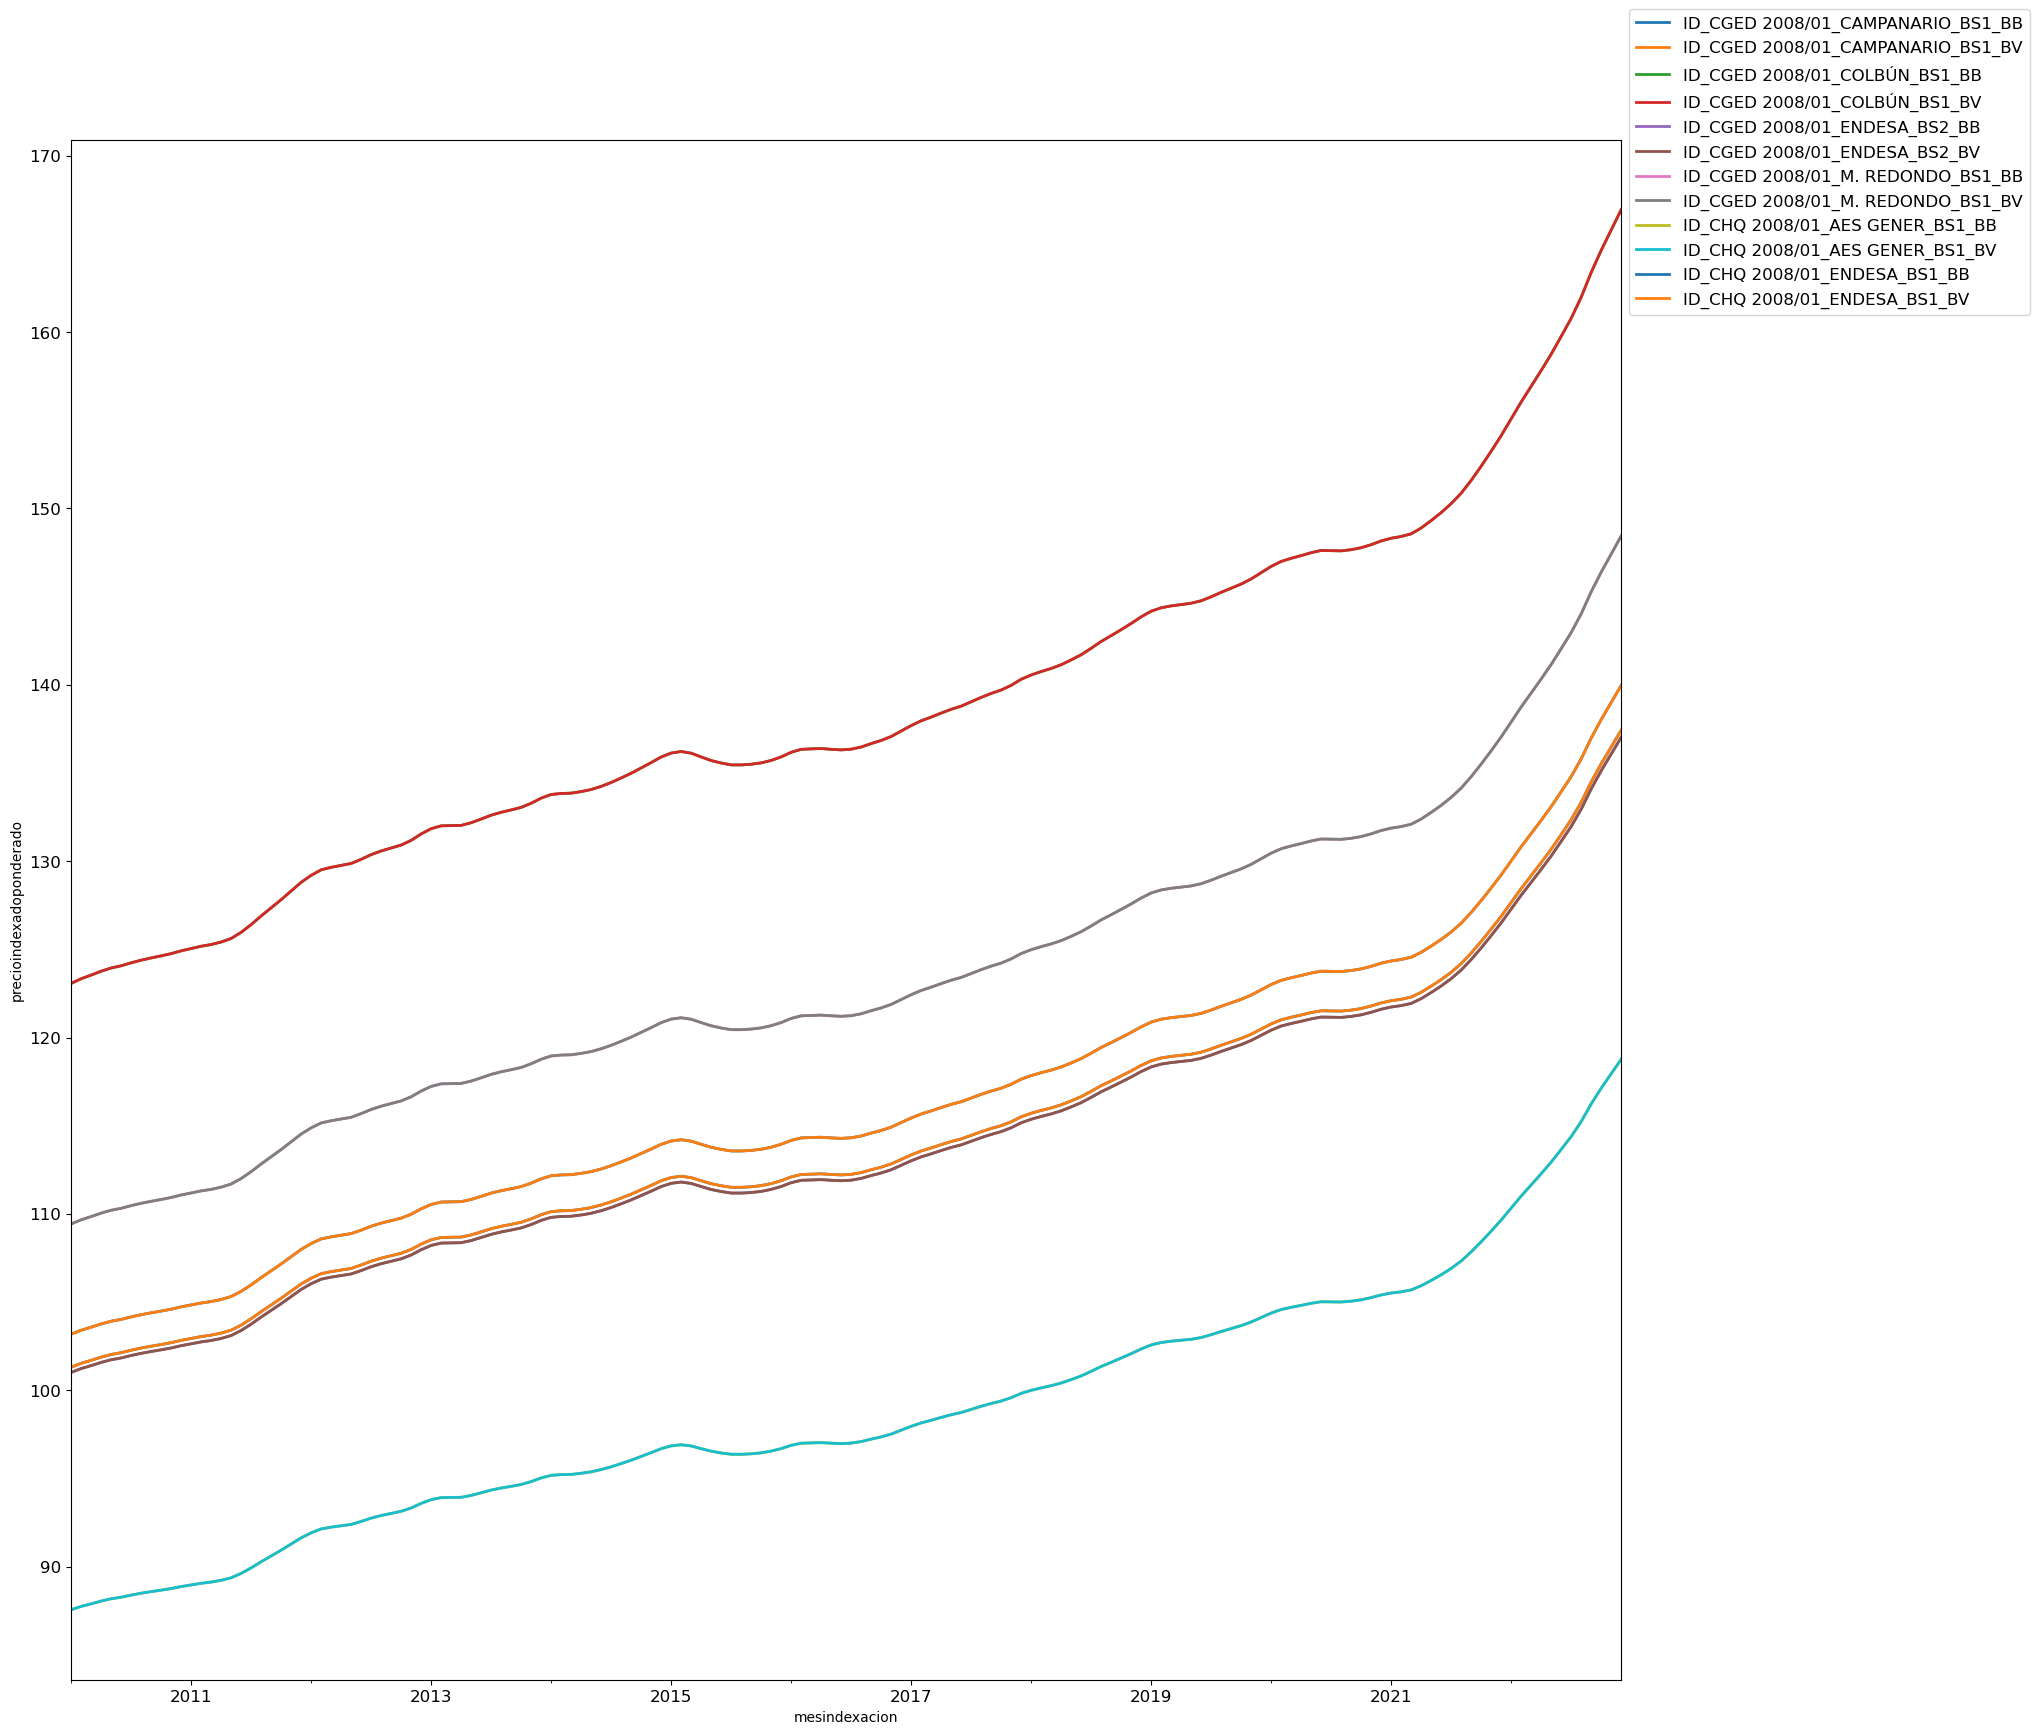

In [ ]:
ax=tablagrupo14.plot(linewidth=2,fontsize=12,figsize=(20,20));

ax.set_xlabel('mesindexacion');
ax.set_ylabel('precioindexadoponderado');
ax.legend(fontsize=12,bbox_to_anchor=(1,1.09),loc='upper left')

#   Arima

Serie 1 'ID_CHQ 2008/01_ENDESA_BS1_BV' comportamiento lineal

Estacionariedad

In [ ]:
series_grupo14 = series_tiempo[(series_tiempo['unique_id'] == grupo14[0])
                              ]

series_grupo14.head()

,mesindexacion,mesindexacion2,añoindexacion,licitacion,generadora,tipobloque,bloque,decpnudo,tipodecreto,mesreferencia,...,indice_CARBÓN,indice_CARBÓN_6M,indice_CPI,indice_CPI_4M,indice_CPI_6M,indice_CPI_9M,indice_GNL,indice_GNL_4M,indice_GNL_6M,unique_id
14,2010-01-01,1,2010,CHQ 2008/01,ENDESA,BV,BS1,130/2008,Decreto PN,1,...,0,0,0,0,0,1,0,0,0,ID_CHQ 2008/01_ENDESA_BS1_BV
32,2010-02-01,2,2010,CHQ 2008/01,ENDESA,BV,BS1,130/2008,Decreto PN,1,...,0,0,0,0,0,1,0,0,0,ID_CHQ 2008/01_ENDESA_BS1_BV
50,2010-03-01,3,2010,CHQ 2008/01,ENDESA,BV,BS1,130/2008,Decreto PN,1,...,0,0,0,0,0,1,0,0,0,ID_CHQ 2008/01_ENDESA_BS1_BV
68,2010-04-01,4,2010,CHQ 2008/01,ENDESA,BV,BS1,130/2008,Decreto PN,1,...,0,0,0,0,0,1,0,0,0,ID_CHQ 2008/01_ENDESA_BS1_BV
86,2010-05-01,5,2010,CHQ 2008/01,ENDESA,BV,BS1,130/2008,Decreto PN,1,...,0,0,0,0,0,1,0,0,0,ID_CHQ 2008/01_ENDESA_BS1_BV


In [ ]:
tablagrupo14=series_grupo14.pivot_table(index='mesindexacion', columns=series_grupo14['unique_id'],values='precioindexadoponderado',aggfunc='sum')

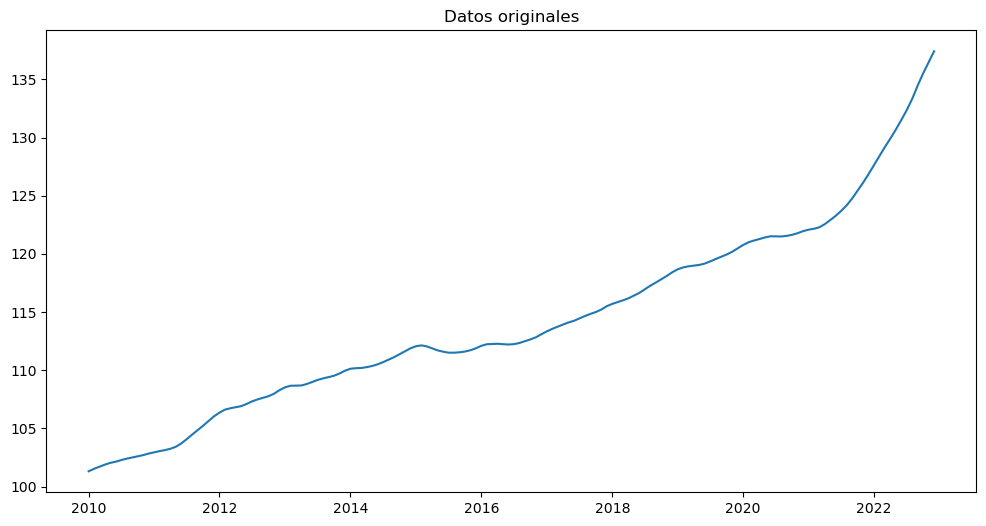

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Visualiza los datos originales
plt.figure(figsize=(12, 6))
plt.plot(tablagrupo14)
plt.title("Datos originales")
plt.show()

In [ ]:
tabla_estandar = tablagrupo14.reset_index()
print(tabla_estandar)

unique_id mesindexacion  ID_CHQ 2008/01_ENDESA_BS1_BV
0            2010-01-01                    101.309840
1            2010-02-01                    101.527043
2            2010-03-01                    101.697027
3            2010-04-01                    101.877872
4            2010-05-01                    102.028969
..                  ...                           ...
151          2022-08-01                    133.333983
152          2022-09-01                    134.488461
153          2022-10-01                    135.521117
154          2022-11-01                    136.477280
155          2022-12-01                    137.422111

[156 rows x 2 columns]


In [ ]:
tabla_estandar.columns

Index(['mesindexacion', 'ID_CHQ 2008/01_ENDESA_BS1_BV'], dtype='object', name='unique_id')

Se aplica diferenciación para que la serie sea estacionaria

In [ ]:
# Aplica la diferenciación de primer orden
tabla_estandar['Diferencia'] = tabla_estandar['ID_CHQ 2008/01_ENDESA_BS1_BV'].diff()
tabla_estandar['Diferencia2'] = tabla_estandar['Diferencia'].diff()
tabla_estandar['Diferencia3'] = tabla_estandar['Diferencia2'].diff()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


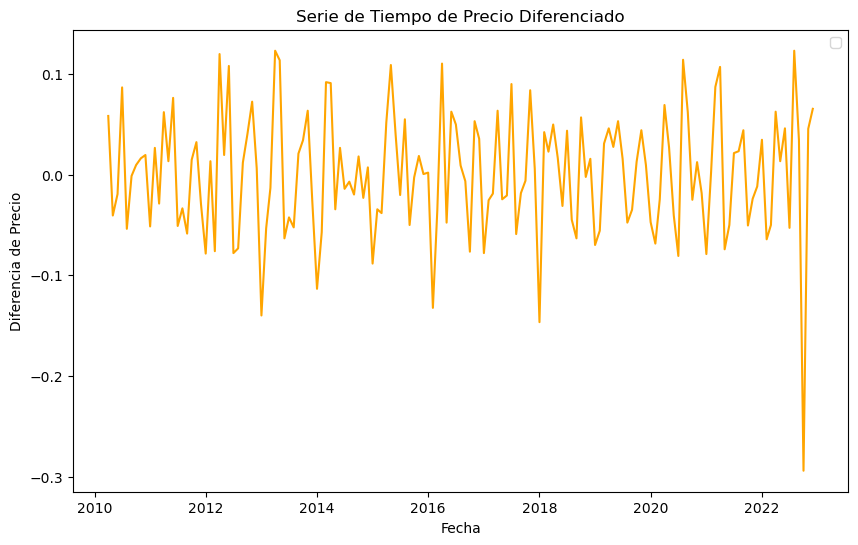

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(tabla_estandar['mesindexacion'], tabla_estandar['Diferencia3'], color='orange')
plt.title('Serie de Tiempo de Precio Diferenciado')
plt.xlabel('Fecha')
plt.ylabel('Diferencia de Precio')
plt.legend()
plt.show()

In [ ]:
tabla_estandar

unique_id,mesindexacion,ID_CHQ 2008/01_ENDESA_BS1_BV,Diferencia,Diferencia2,Diferencia3
0,2010-01-01,101.309840,NaN,NaN,NaN
1,2010-02-01,101.527043,0.217202,NaN,NaN
2,2010-03-01,101.697027,0.169985,-0.047218,NaN
3,2010-04-01,101.877872,0.180845,0.010860,0.058078
4,2010-05-01,102.028969,0.151097,-0.029747,-0.040607
...,...,...,...,...,...
151,2022-08-01,133.333983,0.982605,0.137876,0.122767
152,2022-09-01,134.488461,1.154478,0.171873,0.033997
153,2022-10-01,135.521117,1.032656,-0.121822,-0.293696
154,2022-11-01,136.477280,0.956163,-0.076493,0.045329


Recién en la diferenciación de orden 3 se vuelve estacionaria comprobando con el test de Dickey-Fuller

In [ ]:
from statsmodels.tsa.stattools import adfuller
# Realiza el test de Dickey-Fuller
result = adfuller( tabla_estandar['Diferencia3'].iloc[4:])

# Imprime los resultados del test
print('Estadística de Dickey-Fuller:', result[0])
print('Valor p:', result[1])
print('Valores críticos:', result[4])
print('Número de retrasos utilizados:', result[2])
print('Número de observaciones utilizadas:', result[3])

# Interpreta los resultados
if result[1] <= 0.05:
    print('La serie temporal es estacionaria (rechazamos la hipótesis nula)')
else:
    print('La serie temporal no es estacionaria (no podemos rechazar la hipótesis nula)')

Estadística de Dickey-Fuller: -8.270192095779342
Valor p: 4.816494324865927e-13
Valores críticos: {'1%': -3.4776006742422374, '5%': -2.882265832283648, '10%': -2.5778219289774156}
Número de retrasos utilizados: 10
Número de observaciones utilizadas: 141
La serie temporal es estacionaria (rechazamos la hipótesis nula)


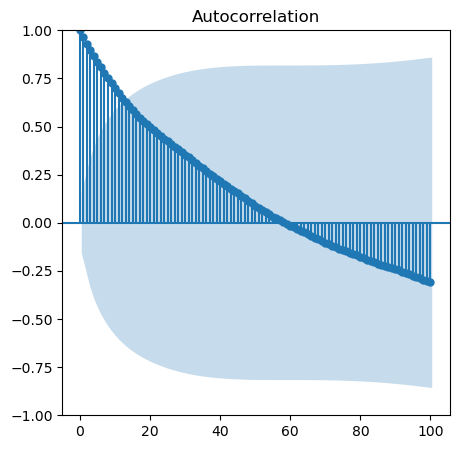

In [ ]:
#realizar grafico acf
plot_acf(tabla_estandar['ID_CHQ 2008/01_ENDESA_BS1_BV'],lags=100)
plt.show()

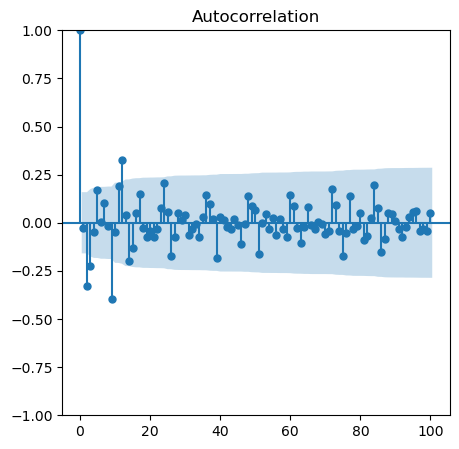

In [ ]:
#realizar grafico acf
plot_acf(tabla_estandar['Diferencia3'].iloc[4:],lags=100)
plt.show()

In [ ]:
#obtener datos acf para ver exactamente en donde esta el maximo
acf_data=acf(tabla_estandar['Diferencia3'].iloc[4:],nlags=400)

acf_data=pd.DataFrame(acf_data,columns=['acf'])

print(acf_data.head(60))

         acf
0   1.000000
1  -0.025991
2  -0.329377
3  -0.223899
4  -0.050336
5   0.168101
6   0.005564
7   0.101892
8  -0.016774
9  -0.396949
10 -0.046458
11  0.188738
12  0.324670
13  0.040964
14 -0.199878
15 -0.131681
16  0.050147
17  0.149235
18 -0.027007
19 -0.075583
20 -0.043524
21 -0.074292
22 -0.034802
23  0.077114
24  0.207518
25  0.055032
26 -0.174865
27 -0.076459
28  0.052040
29  0.014893
30  0.037948
31 -0.061045
32 -0.032362
33 -0.008137
34 -0.075482
35  0.031589
36  0.144304
37  0.097734
38  0.022142
39 -0.181372
40  0.029455
41  0.012004
42 -0.023998
43 -0.030108
44  0.020540
45 -0.013885
46 -0.110112
47 -0.005222
48  0.141350
49  0.088380
50  0.064532
51 -0.162672
52 -0.002353
53  0.043101
54 -0.033696
55  0.023397
56 -0.063655
57  0.018277
58 -0.033699
59 -0.071655


Hasta el momento ARIMA(1,3,5)

c:\Users\Vskah\anaconda3\lib\site-packages\scalecast\_utils.py:60: Warning: Confidence intervals not found for arima1. To turn on confidence intervals for future evaluated models, call the eval_cis() method.
  warnings.warn(


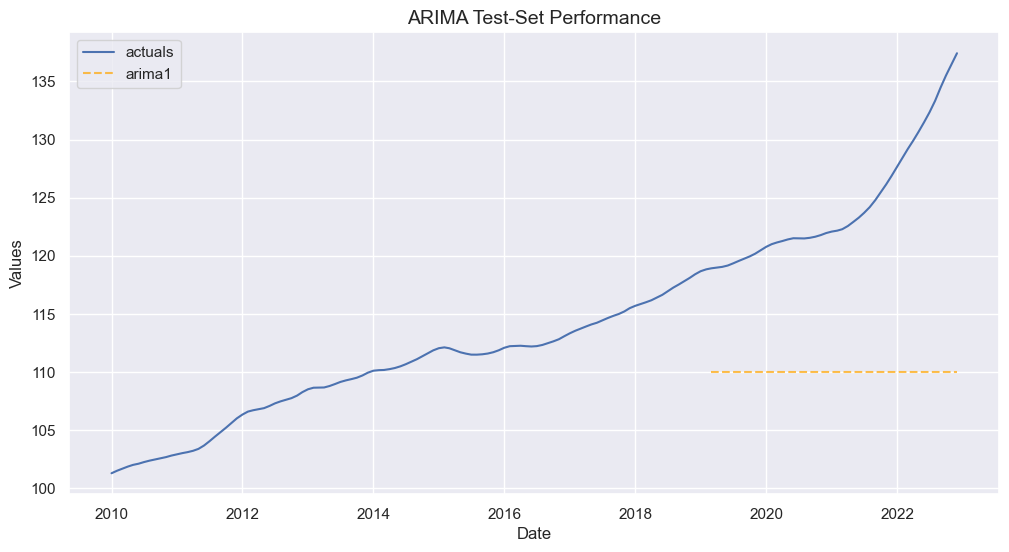

In [ ]:

import pandas as pd
import numpy as np
from scalecast.Forecaster import Forecaster
from pmdarima import auto_arima
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(14,7)})


f = Forecaster(y=tabla_estandar['ID_CHQ 2008/01_ENDESA_BS1_BV'],current_dates=tabla_estandar['mesindexacion'])

f.generate_future_dates(12) # 12-month forecast horizon
f.set_test_length(.3) # 30% test set
f.set_estimator('arima') # set arima
f.manual_forecast(call_me='arima1') # forecast with arima

f.plot_test_set(ci=True) # view test results
plt.title('ARIMA Test-Set Performance',size=14)
plt.show()

Performing stepwise search to minimize aic
 ARIMA(2,2,1)(1,0,1)[12]             : AIC=-500.974, Time=0.54 sec
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=-431.790, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[12]             : AIC=-491.128, Time=0.15 sec
 ARIMA(0,2,1)(0,0,1)[12]             : AIC=-494.886, Time=0.17 sec
 ARIMA(2,2,1)(0,0,1)[12]             : AIC=-490.790, Time=0.28 sec
 ARIMA(2,2,1)(1,0,0)[12]             : AIC=-495.629, Time=0.36 sec
 ARIMA(2,2,1)(2,0,1)[12]             : AIC=-500.000, Time=1.78 sec
 ARIMA(2,2,1)(1,0,2)[12]             : AIC=-500.283, Time=1.88 sec
 ARIMA(2,2,1)(0,0,0)[12]             : AIC=-480.193, Time=0.11 sec
 ARIMA(2,2,1)(0,0,2)[12]             : AIC=-491.113, Time=1.54 sec
 ARIMA(2,2,1)(2,0,0)[12]             : AIC=-494.964, Time=1.08 sec
 ARIMA(2,2,1)(2,0,2)[12]             : AIC=-497.914, Time=2.49 sec
 ARIMA(1,2,1)(1,0,1)[12]             : AIC=-502.994, Time=0.46 sec
 ARIMA(1,2,1)(0,0,1)[12]             : AIC=-492.904, Time=0.24 sec
 ARIMA(1,2,1)(1,0,0

c:\Users\Vskah\anaconda3\lib\site-packages\scalecast\_utils.py:60: Warning: Confidence intervals not found for arima3. To turn on confidence intervals for future evaluated models, call the eval_cis() method.
  warnings.warn(


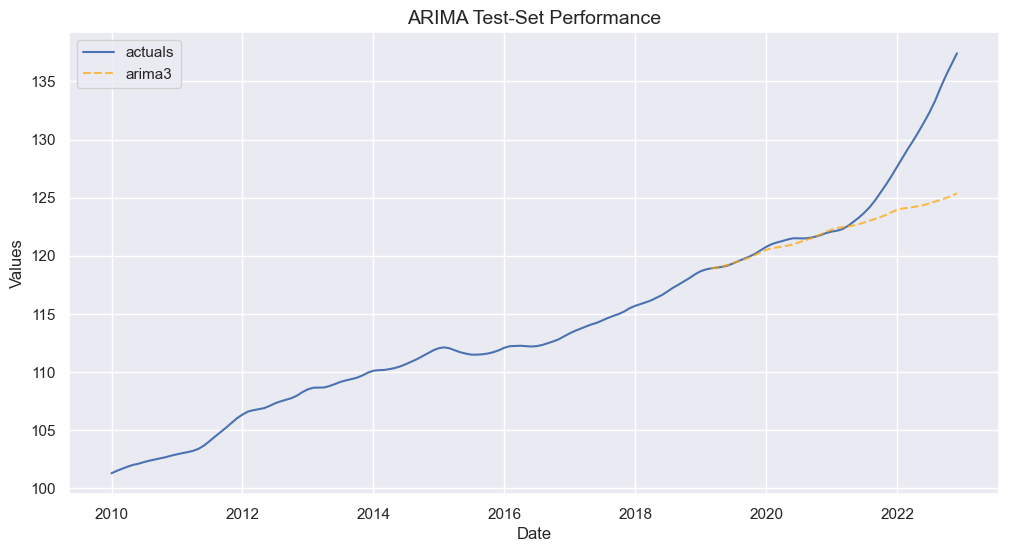

c:\Users\Vskah\anaconda3\lib\site-packages\scalecast\_utils.py:60: Warning: Confidence intervals not found for arima3. To turn on confidence intervals for future evaluated models, call the eval_cis() method.
  warnings.warn(


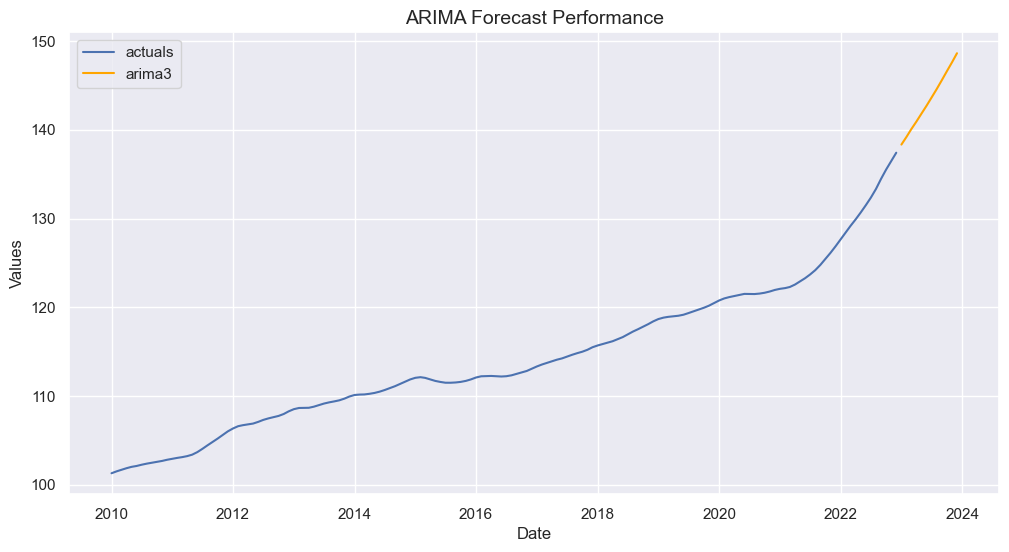

In [ ]:
from scalecast.auxmodels import auto_arima
from sklearn.metrics import mean_absolute_error, mean_squared_error

auto_arima(
    f,
    start_P=1,
    start_q=1,
    max_p=6,
    max_q=6,
    m=12,
    seasonal=True,
    max_P=2,
    max_D=2,
    max_Q=2,
    max_d=3,
    trace=True,
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True,
    information_criterion="aic",
    alpha=0.05,
    scoring='mse',
    call_me='arima3',
)

f.plot_test_set(ci=True,models='arima3')
plt.title('ARIMA Test-Set Performance',size=14)
plt.show()

f.plot(ci=True,models='arima3')
plt.title('ARIMA Forecast Performance',size=14)
plt.show()



MAE: 0.05705160
MAPE: 8.96328831%
MSE: 0.00449960


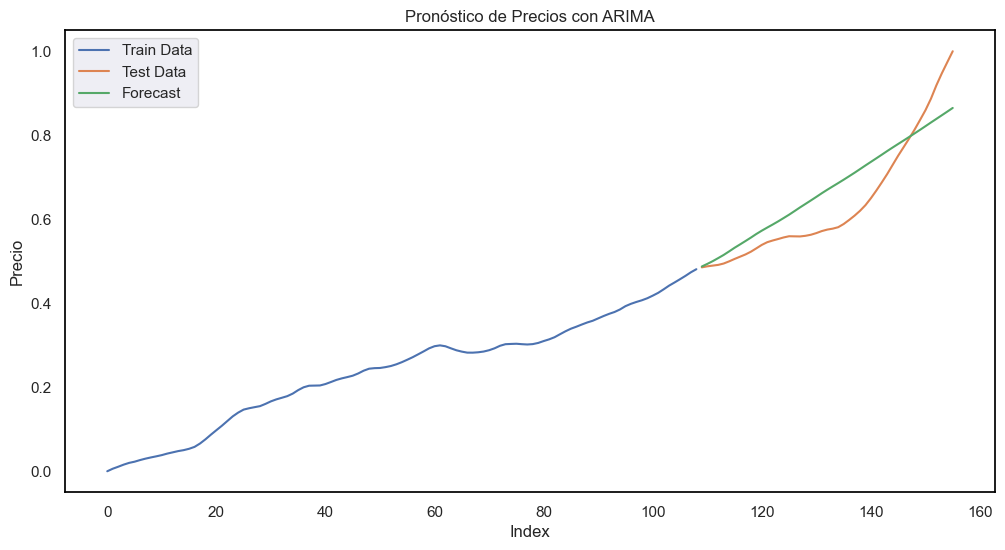

In [ ]:
import statsmodels.api as sm
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt

# Copia de seguridad de la serie temporal original
original_series = tabla_estandar['ID_CHQ 2008/01_ENDESA_BS1_BV'].copy()

# Normaliza los datos utilizando Min-Max scaling
scaler = MinMaxScaler()
tabla_estandar['ID_CHQ 2008/01_ENDESA_BS1_BV'] = scaler.fit_transform(tabla_estandar['ID_CHQ 2008/01_ENDESA_BS1_BV'].values.reshape(-1, 1))

# Divide los datos en entrenamiento y prueba
train_size = int(len(tabla_estandar) * 0.7)
train, test = tabla_estandar.iloc[:train_size], tabla_estandar.iloc[train_size:]

# Ajusta el modelo ARIMA
order = (0, 2, 1)
seasonal_order = (1, 0, 1, 12)
model = sm.tsa.SARIMAX(train['ID_CHQ 2008/01_ENDESA_BS1_BV'], order=order, seasonal_order=seasonal_order)
results = model.fit()

# Realiza pronósticos en el conjunto de prueba
forecast_steps = len(test)
forecast = results.get_forecast(steps=forecast_steps)

# Extrae la serie de precios pronosticados
predicted_prices_normalized = forecast.predicted_mean

# Desnormaliza los datos de pronóstico
predicted_prices = scaler.inverse_transform(predicted_prices_normalized.values.reshape(-1, 1)).flatten()

# Extrae la serie de precios reales del conjunto de prueba
actual_prices = original_series.iloc[train_size:]

# Calcula el MAE
mae = mean_absolute_error(actual_prices, predicted_prices)

# Calcula el MAPE
mape = np.mean(np.abs((actual_prices - predicted_prices) / actual_prices)) * 100

# Calcula el MSE
mse = mean_squared_error(actual_prices, predicted_prices)

print(f'MAE: {mae:.8f}')
print(f'MAPE: {mape:.8f}%')
print(f'MSE: {mse:.8f}')

# Visualiza los resultados
plt.figure(figsize=(12, 6))
plt.plot(original_series.iloc[:train_size], label='Train Data')
plt.plot(actual_prices, label='Test Data')
plt.plot(test.index, predicted_prices, label='Forecast')
plt.title('Pronóstico de Precios con ARIMA')
plt.xlabel('Index')
plt.ylabel('Precio')
plt.legend()
plt.grid(True)
plt.gca().set_facecolor('white')
for spine in plt.gca().spines.values():
    spine.set_edgecolor('black')
plt.show()